In [1]:
# Install packages
!pip install pennylane pennylane-lightning pennylane-lightning[gpu] cotengra quimb --upgrade
!pip install -U "jax[cuda12_pip]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
# !pip install --upgrade "jax[cuda11_pip]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 33.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 76.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.8/177.8 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 541.6/541.6 kB 33.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 66.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 59.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 21.1 MB/s eta 0:00:00
Looking in links: https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.1/86.1 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.9/14.9 MB 28.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1

In [2]:
# Import packages
import matplotlib as mpl
import matplotlib.pyplot as plt
import sys
import numpy as np
#np.set_printoptions(threshold=sys.maxsize)
import pandas as pd
from sklearn import datasets
import seaborn as sns
import jax
import time

import functools

from typing import List, Union, Tuple, Dict, Optional, Any
from typing import Callable

jax.config.update("jax_enable_x64", True)
#jax.config.update("jax_debug_nans", True)
import jax.numpy as jnp

import optax  # optimization using jax

import torch  # https://pytorch.org
import torchvision  # https://pytorch.org
#torch.set_printoptions(profile="full")
import pennylane as qml
import pennylane.numpy as pnp

import os, cv2, itertools # cv2 -- OpenCV
import shutil
import zipfile
%matplotlib inline

from jax.lib import xla_bridge

def set_jax_platform():
    # Check if TPU is available
    try:
        tpu_backend = xla_bridge.get_backend('tpu')
        if tpu_backend and tpu_backend.device_count() > 0:
            # Set platform to TPU
            jax.config.update('jax_platform_name', 'tpu')
            print("Set platform to TPU")
            return
    except RuntimeError:
        pass  # No TPU found, move on to check for GPU

    # Check if GPU is available
    try:
      gpu_backend = xla_bridge.get_backend('gpu')
      if gpu_backend and gpu_backend.device_count() > 0:
          # Set platform to CUDA (GPU)
          jax.config.update('jax_platform_name', 'gpu')
          print("Set platform to GPU")
    except RuntimeError:
          # Set platform to CPU
          jax.config.update('jax_platform_name', 'cpu')
          print("Set platform to CPU")

# Call the function to set the platform
set_jax_platform()

sns.set()

seed = 1701
rng = np.random.default_rng(seed=seed)
prng = pnp.random.default_rng(seed=seed)
jrng_key = jax.random.PRNGKey(seed)

<ipython-input-2-b00b07bf67a6>:40: DeprecationWarning: jax.lib.xla_bridge.get_backend is deprecated; use jax.extend.backend.get_backend.
  tpu_backend = xla_bridge.get_backend('tpu')
<ipython-input-2-b00b07bf67a6>:51: DeprecationWarning: jax.lib.xla_bridge.get_backend is deprecated; use jax.extend.backend.get_backend.
  gpu_backend = xla_bridge.get_backend('gpu')


Set platform to GPU


# Prepare the Dataset

For the rescaled image matrix $M$, the "Hermitian version" of it can be calculated as:

$$
A = \frac{M+M^T}{2}
$$

In [3]:
preprocess = torchvision.transforms.Compose([
    torchvision.transforms.Pad(2),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Lambda(lambda x: torch.squeeze(x)),
    #torchvision.transforms.Lambda(lambda x: x / torch.trace(x)),
    torchvision.transforms.Lambda(lambda x: (x+torch.transpose(x, 0, 1))/2)
])

train_dataset = torchvision.datasets.MNIST(
    "MNIST",
    train=True,
    download=True,
    transform=preprocess,
)
test_dataset = torchvision.datasets.MNIST(
    "MNIST",
    train=False,
    download=True,
    transform=preprocess,
)
dummy_trainloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=64, shuffle=True
)
dummy_testloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=64, shuffle=True
)

dummy_x, dummy_y = next(iter(dummy_trainloader))
dummy_x = dummy_x.numpy()
dummy_y = dummy_y.numpy()
print(dummy_x.shape)  # 64x32x32
print(dummy_y.shape)  # 64
print(dummy_y)
print(dummy_x[0,16])

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 16280584.06it/s]


Extracting MNIST/MNIST/raw/train-images-idx3-ubyte.gz to MNIST/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 494036.17it/s]


Extracting MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to MNIST/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 4452523.74it/s]


Extracting MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 3031110.38it/s]

Extracting MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST/MNIST/raw

(64, 32, 32)
(64,)
[1 4 9 8 7 1 6 1 1 7 0 3 6 6 8 5 9 3 4 6 5 5 7 2 8 1 2 9 1 3 9 0 0 8 2 0 6
 4 4 0 1 5 5 2 0 0 6 6 9 0 2 2 3 2 1 0 2 7 7 1 8 4 3 4]
[0.         0.         0.         0.         0.         0.
 0.         0.         0.19215687 0.29215688 0.29215688 0.29215688
 0.4019608  0.49607843 0.57058823 0.927451   0.99607843 0.79019606
 0.49607843 0.49607843 0.49607843 0.49607843 0.49607843 0.49607843
 0.49607843 0.49607843 0.         0.         0.         0.
 0.         0.        ]


# Time-Evolve the Image Hermitian

In [4]:
def img_hermitian_evolve(
    img:jnp.ndarray,
    t:float
)->jnp.ndarray:
  assert img.shape[-1]==32 and img.shape[-2] == 32, f"The shape of the image must be 32 by 32, got {img.shape[-2]} by {img.shape[-1]}"
  return jax.scipy.linalg.expm(img*( -0.5j*t))

print(
    img_hermitian_evolve(
        dummy_x[0],
        10
        )[16]
    )


print(
    jnp.einsum(
        "ij,jk->ik",
        jnp.transpose(jnp.conjugate(img_hermitian_evolve(
        dummy_x[0],
        10
        ))),
        img_hermitian_evolve(
        dummy_x[0],
        10
        )
    )
)

print(
    jnp.einsum(
        "ij,jk->ik",
        img_hermitian_evolve(
        dummy_x[0],
        10
        ),
        jnp.transpose(jnp.conjugate(img_hermitian_evolve(
        dummy_x[0],
        10
        )))
    )
)

[ 0.        +0.j          0.        +0.j          0.        +0.j
  0.        +0.j          0.        +0.j          0.        +0.j
 -0.08425658+0.27362376j -0.11163641+0.34952053j -0.05980267+0.01368771j
 -0.05330864-0.12267236j -0.02982646-0.14010537j -0.03196526-0.08992453j
 -0.00083861-0.23477529j -0.05506559-0.16507737j  0.35857216+0.12227695j
  0.34855375+0.09667016j  0.15120251+0.17321242j -0.03118993-0.0414421j
  0.18919455+0.00185021j  0.22574805+0.17663069j -0.00412213-0.01116842j
 -0.09731125-0.15229319j  0.15256386-0.14876023j  0.09566949+0.20120546j
  0.09373346+0.22009434j  0.10792629+0.04608551j  0.        +0.j
  0.        +0.j          0.        +0.j          0.        +0.j
  0.        +0.j          0.        +0.j        ]
[[1.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 1.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 1.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 ...
 [0.+0.j 0.+0.j 0.+0.j ... 1.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 1.+0.j 0.+0.j]
 [0

# Some Utilities

In [5]:
ket = {
    '0':jnp.array([1,0]),
    '1':jnp.array([0,1]),
    '+':(jnp.array([1,0]) + jnp.array([0,1]))/jnp.sqrt(2),
    '-':(jnp.array([1,0]) - jnp.array([0,1]))/jnp.sqrt(2)
}

pauli = {
    'I':jnp.array([[1,0],[0,1]]),
    'X':jnp.array([[0,1],[1,0]]),
    'Y':jnp.array([[0, -1j],[1j, 0]]),
    'Z':jnp.array([[1,0],[0,-1]])
}

def tensor_product(*args):
  input_list = [a for a in args]
  return functools.reduce(jnp.kron, input_list)

def multi_qubit_identity(n_qubits:int)->jnp.ndarray:
  assert n_qubits>0
  if n_qubits == 1:
    return pauli['I']
  else:
    return tensor_product(*[pauli['I'] for _ in range(n_qubits)])

pauli_words_su4 = {}
for key1 in pauli.keys():
  for key2 in pauli.keys():
    if not (key1==key2 and key1=='I' and key2=='I'):
      pauli_words_su4[key1+key2] = tensor_product(pauli[key1], pauli[key2])

pauli_words_su8 = {}
for key1 in pauli.keys():
  for key2 in pauli.keys():
    for key3 in pauli.keys():
      if not key1+key2+key3 == 'III':
        pauli_words_su8[key1+key2+key3] = tensor_product(pauli[key1], pauli[key2], pauli[key3])

pauli_words_su16 = {}
for key1 in pauli.keys():
  for key2 in pauli.keys():
    for key3 in pauli.keys():
      for key4 in pauli.keys():
        if not key1+key2+key3+key4 == 'IIII':
          pauli_words_su16[key1+key2+key3+key4] = tensor_product(
              pauli[key1],
              pauli[key2],
              pauli[key3],
              pauli[key4]
          )

pauli_words_su32 = {}
for key1 in pauli.keys():
  for key2 in pauli.keys():
    for key3 in pauli.keys():
      for key4 in pauli.keys():
        for key5 in pauli.keys():
          if not key1+key2+key3+key4+key5 == 'IIIII':
            pauli_words_su32[key1+key2+key3+key4+key5] = tensor_product(
                pauli[key1],
                pauli[key2],
                pauli[key3],
                pauli[key4],
                pauli[key5]
            )

observables_10_cls_5q = [0]*10
for i in ['0', '1']:
  for j in ['0', '1']:
    for k in ['0', '1']:
      for l in ['0', '1']:
        idx = int(i+j+k+l, 2)
        if idx <10:
          basis_state = tensor_product(*[ket[i], ket[j], ket[k], ket[l]])
          four_qubit_obs = jnp.outer(basis_state, basis_state)
          observables_10_cls_5q[idx] = tensor_product(four_qubit_obs, multi_qubit_identity(1))

observables_8_cls_5q = [0]*8
for i in ['0', '1']:
  for j in ['0', '1']:
    for k in ['0', '1']:
      for l in ['0', '1']:
        idx = int(i+j+k+l, 2)
        if idx <8:
          basis_state = tensor_product(*[ket[i], ket[j], ket[k], ket[l]])
          four_qubit_obs = jnp.outer(basis_state, basis_state)
          observables_8_cls_5q[idx] = tensor_product(four_qubit_obs, multi_qubit_identity(1))


In [6]:
def su32_op(
    params:jnp.ndarray
):
  generator = jnp.einsum("i, ijk - >jk", params, jnp.asarray(list(pauli_words_su32.values())))
  return jax.scipy.linalg.expm(1j*generator)

test_params = jax.random.normal(shape=[4**5-1], key=jrng_key)

print(
    jnp.einsum(
        "ij,jk->ik",
        jnp.transpose(jnp.conjugate(su32_op(test_params))),
        su32_op(test_params)
    )
)

print(
    jnp.einsum(
        "ij,jk->ik",
        su32_op(test_params),
        jnp.transpose(jnp.conjugate(su32_op(test_params)))
    )
)

[[ 1.00000000e+00-2.81802478e-18j -2.08166817e-17-6.93889390e-17j
   1.87350135e-16+4.02455846e-16j ...  6.78276879e-16-5.07189776e-16j
  -7.11236625e-16+6.24500451e-17j -2.53269627e-16-5.55111512e-16j]
 [-2.08166817e-17+4.85722573e-17j  1.00000000e+00+1.79597214e-18j
   3.78169718e-16-5.82867088e-16j ...  8.04911693e-16-1.17267307e-15j
   4.85722573e-17-4.51089090e-16j -2.35922393e-16-2.22044605e-16j]
 [ 1.87350135e-16-3.95516953e-16j  3.78169718e-16+5.55111512e-16j
   1.00000000e+00-1.01336686e-18j ...  6.38378239e-16+8.18789481e-16j
  -2.74086309e-16-5.20417043e-16j  4.85722573e-17-4.23272528e-16j]
 ...
 [ 6.81746326e-16+5.07189776e-16j  7.91033905e-16+1.17267307e-15j
   6.93889390e-16-8.18789481e-16j ...  1.00000000e+00-1.40196419e-18j
  -1.75207071e-16+8.53483950e-16j  3.46944695e-16-6.38378239e-16j]
 [-7.04297731e-16-6.24500451e-17j  4.16333634e-17+4.51089090e-16j
  -2.63677968e-16+5.20417043e-16j ... -1.75207071e-16-8.60422844e-16j
   1.00000000e+00+4.01611805e-18j -1.38777878e-

In [7]:
def measure_sv(
    state:jnp.ndarray,
    observable:jnp.ndarray
    ):
  """
  Measure a statevector with a Hermitian observable.
  Note: No checking Hermitianicity of the observable or whether the observable
  has all real eigenvalues or not
  """
  expectation_value = jnp.dot(jnp.conj(state.T), jnp.dot(observable, state))
  return jnp.real(expectation_value)

def measure_dm(
    rho:jnp.ndarray,
    observable:jnp.ndarray
):
  """
  Measure a density matrix with a Hermitian observable.
  Note: No checking Hermitianicity of the observable or whether the observable
  has all real eigenvalues or not.
  """
  product = jnp.dot(rho, observable)

  # Calculate the trace, which is the sum of diagonal elements
  trace = jnp.trace(product)

  # The expectation value should be real for physical observables
  return jnp.real(trace)

vmap_measure_sv = jax.vmap(measure_sv, in_axes=(None, 0), out_axes=0)
vmap_measure_dm = jax.vmap(measure_dm, in_axes=(None, 0), out_axes=0)

def bitstring_to_state(bitstring:str):
  """
  Convert a bit string, like '0101001' or '+-+-101'
  to a statevector. Each character in the bitstring must be among
  0, 1, + and -
  """
  assert len(bitstring)>0
  for c in bitstring:
    assert c in ['0', '1', '+', '-']
  single_qubit_states = [ket[c] for c in bitstring]
  return tensor_product(*single_qubit_states)

# The QNN

With data re-uploading

$$
|{\varphi(\theta,t)}\rangle = \Pi_n (\mathrm{ParameterisedLayers}(\theta_n) e^{-\frac{it_n}{2}M} )|+\rangle^{\otimes 5}
$$

In [8]:
def qnn_hamevo(
    params:jnp.ndarray,
    t:jnp.ndarray,
    img:jnp.ndarray
)->jnp.ndarray:
  """
  A QNN that takes (M+M^T)/2
  as input, where M is the (rescaled) original image,
  as well as a trainable parameter t,
  and parameters for trainable layers
  and output an array of 2 elements representing classification logits
  """
  single_op_params = 4**5-1

  n_outer_layers = len(t)
  n_inner_layers = (len(params)//single_op_params)//n_outer_layers
  state = tensor_product(ket['+'], ket['+'], ket['+'], ket['+'], ket['+'])
  for i in range(n_outer_layers):
    state = jnp.dot(
      img_hermitian_evolve(img, t[i]),
      state
      )
    inner_layer_params = params[i*(single_op_params*n_inner_layers):(i+1)*(single_op_params*n_inner_layers)]
    for j in range(n_inner_layers):
      state = jnp.dot(
          #brickwall_su4_5q_single_layer(inner_layer_params[j*single_op_params:(j+1)*single_op_params]),
          su32_op(inner_layer_params[j*single_op_params:(j+1)*single_op_params]),
          state
      )
  return vmap_measure_sv(state, jnp.asarray(observables_8_cls_5q))



print(
    qnn_hamevo(
        jax.random.normal(shape=[( 4**5-1)*15], key=jrng_key),
        jax.random.normal(shape=[15], key=jrng_key),
        dummy_x[0]
    )
)

[0.0662222  0.01141476 0.0228869  0.07490359 0.16326536 0.04935118
 0.01021365 0.02042996]


# Training

In [9]:
@jax.jit
def compute_out(weight,t, features, labels):
    """Computes the output of the corresponding label in the qcnn"""
    out = lambda weight,t, feature, label: qnn_hamevo(weight,t, feature)
    return jax.vmap(out, in_axes=(None,None,  0, 0), out_axes=0)(
        weight,t, features, labels
    )


def compute_accuracy(weight,t, features, labels):
    """Computes the accuracy over the provided features and labels"""
    out = compute_out(weight,t, features, labels)
    pred = jnp.argmax(out, axis = 1)
    return jnp.sum(jnp.array(pred == labels).astype(int)) / len(out)


def compute_cost(weight,t, features, labels):
    """Computes the cost over the provided features and labels"""
    logits = compute_out(weight,t, features, labels)
    return jnp.nanmean(optax.softmax_cross_entropy_with_integer_labels(logits, labels))


value_and_grad = jax.jit(jax.value_and_grad(compute_cost, argnums=[0,1]))

In [10]:
N_OUTER_LAYERS = 10
N_INNER_LAYERS = 1
N_LAYERS = N_OUTER_LAYERS*N_INNER_LAYERS
SINGLE_OP_PARAMS  = 4**5-1

# def init_weights():
#     return jax.random.normal(shape=[SINGLE_OP_PARAMS*N_LAYERS], key=jrng_key),jax.random.normal(shape=[N_OUTER_LAYERS], key=jrng_key)

def init_weights(alpha=0.5, beta=2.0):
    # Initialize weights with a Beta distribution skewed towards 0
    weights = jax.random.beta(jrng_key, alpha, beta, shape=[SINGLE_OP_PARAMS*N_LAYERS])
    biases = jax.random.beta(jrng_key, alpha, beta, shape=[N_OUTER_LAYERS])
    return weights, biases

In [11]:
# select data
labels = [0,1,2,3,4,5,6,7,8,9]
indices_train = [idx for idx, target in enumerate(train_dataset.targets) if target in labels]
indices_test = [idx for idx, target in enumerate(test_dataset.targets) if target in labels]

N_TRAIN = len(indices_train)
N_TEST = len(indices_test)

print(
    f"Training with: {N_TRAIN}; Testing with: {N_TEST}"
)

def train_vqc(batchsize:int, n_epochs:int, seed:int=1701):
  start = time.time()
  pnp.random.seed(seed)
  np.random.seed(seed)
  # load data
  labels = [0,1,2,3,4,5,6,7,8,9]
  indices_train = [idx for idx, target in enumerate(train_dataset.targets) if target in labels]
  indices_test = [idx for idx, target in enumerate(test_dataset.targets) if target in labels]
  trainloader = torch.utils.data.DataLoader(
  torch.utils.data.Subset(train_dataset, indices_train), batch_size=batchsize, shuffle=True
)
  testloader = torch.utils.data.DataLoader(
  torch.utils.data.Subset(test_dataset, indices_test), batch_size=batchsize, shuffle=True
)
  # Exponential decay of the learning rate.
  scheduler = optax.exponential_decay(
    init_value=0.01,
    transition_steps=n_epochs,
    decay_rate=0.99)

  # Combining gradient transforms using `optax.chain`.
  gradient_transform = optax.chain(
    optax.clip(1.0),
    optax.scale_by_adam(),  # Use the updates from adam.
    optax.scale_by_schedule(scheduler),  # Use the learning rate from the scheduler.
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
  )
  # init weights and optimizer
  # weights, weights_last = init_weights() # for normal
  weights, weights_last = init_weights(0.5,2.0) # for beta

  opt_state = gradient_transform.init((weights, weights_last))
  #data containers
  train_cost_epochs, test_cost_epochs, train_acc_epochs, test_acc_epochs = [], [], [], []
  for step in range(n_epochs):
        train_cost_batches = []
        train_acc_batches = []
        test_cost_batches = []
        test_acc_batches = []
        epoch_start = time.time()
        print(f"Training at Epoch {step+1}/{n_epochs}, Train batches {len(trainloader)}, Test batches {len(testloader)}......")
        for batch, (x_train, y_train) in enumerate(trainloader):
          batch_start = time.time()
          # Training step with (adam) optimizer
          x_train, y_train = jnp.asarray(x_train.numpy()), jnp.asarray(y_train.numpy())
          train_cost, grad_circuit = value_and_grad(weights, weights_last, x_train, y_train)
          updates, opt_state = gradient_transform.update(grad_circuit, opt_state)
          weights, weights_last = optax.apply_updates((weights, weights_last), updates)
          train_acc = compute_accuracy(weights, weights_last, x_train, y_train)
          train_cost_batches.append(train_cost)
          train_acc_batches.append(train_acc)
          if len(trainloader)<= 5 or (batch+1)%5==0:
            print(f"Training at Epoch {step+1}/{n_epochs}, Batch {batch+1}, Cost {train_cost}, Acc {train_acc}. Time {time.time()-batch_start}")


        train_cost_epochs.append(np.mean(train_cost_batches))
        train_acc_epochs.append(np.mean(train_acc_batches))


        # load test data
        for batch, (x_test, y_test) in enumerate(testloader):
          batch_start = time.time()
          x_test, y_test = jnp.asarray(x_test.numpy()), jnp.asarray(y_test.numpy())
          # compute accuracy and cost on testing data
          test_out = compute_out(weights, weights_last, x_test, y_test)
          test_pred = jnp.argmax(test_out, axis=1)
          test_acc = jnp.sum(jnp.array(test_pred == y_test).astype(int)) / len(test_out)
          test_cost = jnp.nanmean(optax.softmax_cross_entropy_with_integer_labels(test_out, y_test))
          test_cost_batches.append(test_cost)
          test_acc_batches.append(test_acc)
          if len(testloader)<= 5 or (batch+1)%5==0:
            print(f"Testing at Epoch {step+1}/{n_epochs}, Batch {batch+1}, Cost {test_cost}, Acc {test_acc}. Time {time.time()-batch_start}")
        test_acc_epochs.append(np.mean(test_acc_batches))
        test_cost = np.mean(test_cost_batches)
        test_cost_epochs.append(test_cost)
        print("......")
        print(f"Epoch {step+1}/{n_epochs}, Train: Cost {np.mean(train_cost_batches)}, Acc {np.mean(train_acc_batches)}")
        print(f"Epoch {step+1}/{n_epochs}, Test: Cost {test_cost}, Acc {test_acc}. Time {time.time()-epoch_start}")
        print("=-="*10)

  return dict(
        n_train=[N_TRAIN] * n_epochs,
        step=np.arange(1, n_epochs + 1, dtype=int).tolist(),
        train_cost=[c.astype(float) for c in train_cost_epochs],
        train_acc=[c.astype(float) for c in train_acc_epochs],
        test_cost=[c.astype(float) for c in test_cost_epochs],
        test_acc=[c.astype(float) for c in test_acc_epochs],
    )

Training with: 60000; Testing with: 10000


In [12]:
n_epochs = 25
n_reps = 1
batch_size = 500

train_sizes = [N_TRAIN]

def run_iterations():
    results_df = pd.DataFrame(
        columns=["train_acc", "train_cost", "test_acc", "test_cost", "step", "n_train"]
    )

    for _ in range(n_reps):
        results = train_vqc(n_epochs=n_epochs, batchsize=batch_size)
        results_df = pd.concat(
            [results_df, pd.DataFrame.from_dict(results)], axis=0, ignore_index=True
        )

    return results_df

results_df = run_iterations()

Training at Epoch 1/25, Train batches 120, Test batches 20......


/usr/local/lib/python3.10/dist-packages/jax/_src/lax/lax.py:3227: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)


Training at Epoch 1/25, Batch 5, Cost 2.029289246793329, Acc 0.256. Time 1.3549363613128662
Training at Epoch 1/25, Batch 10, Cost 1.9300579078145048, Acc 0.504. Time 1.3565199375152588
Training at Epoch 1/25, Batch 15, Cost 1.8678731660285615, Acc 0.542. Time 1.3752751350402832
Training at Epoch 1/25, Batch 20, Cost 1.837280234102852, Acc 0.538. Time 1.3685142993927002
Training at Epoch 1/25, Batch 25, Cost 1.8181887759200175, Acc 0.63. Time 1.359377384185791
Training at Epoch 1/25, Batch 30, Cost 1.8066651056053744, Acc 0.6. Time 1.3574020862579346
Training at Epoch 1/25, Batch 35, Cost 1.7774442794548204, Acc 0.616. Time 1.338569164276123
Training at Epoch 1/25, Batch 40, Cost 1.7706127315284064, Acc 0.626. Time 1.3459606170654297
Training at Epoch 1/25, Batch 45, Cost 1.758234925242113, Acc 0.618. Time 1.3286020755767822
Training at Epoch 1/25, Batch 50, Cost 1.7307015070712422, Acc 0.618. Time 1.3562514781951904
Training at Epoch 1/25, Batch 55, Cost 1.7273619270992593, Acc 0.638.

<ipython-input-12-cdab6e19e1eb>:14: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat(


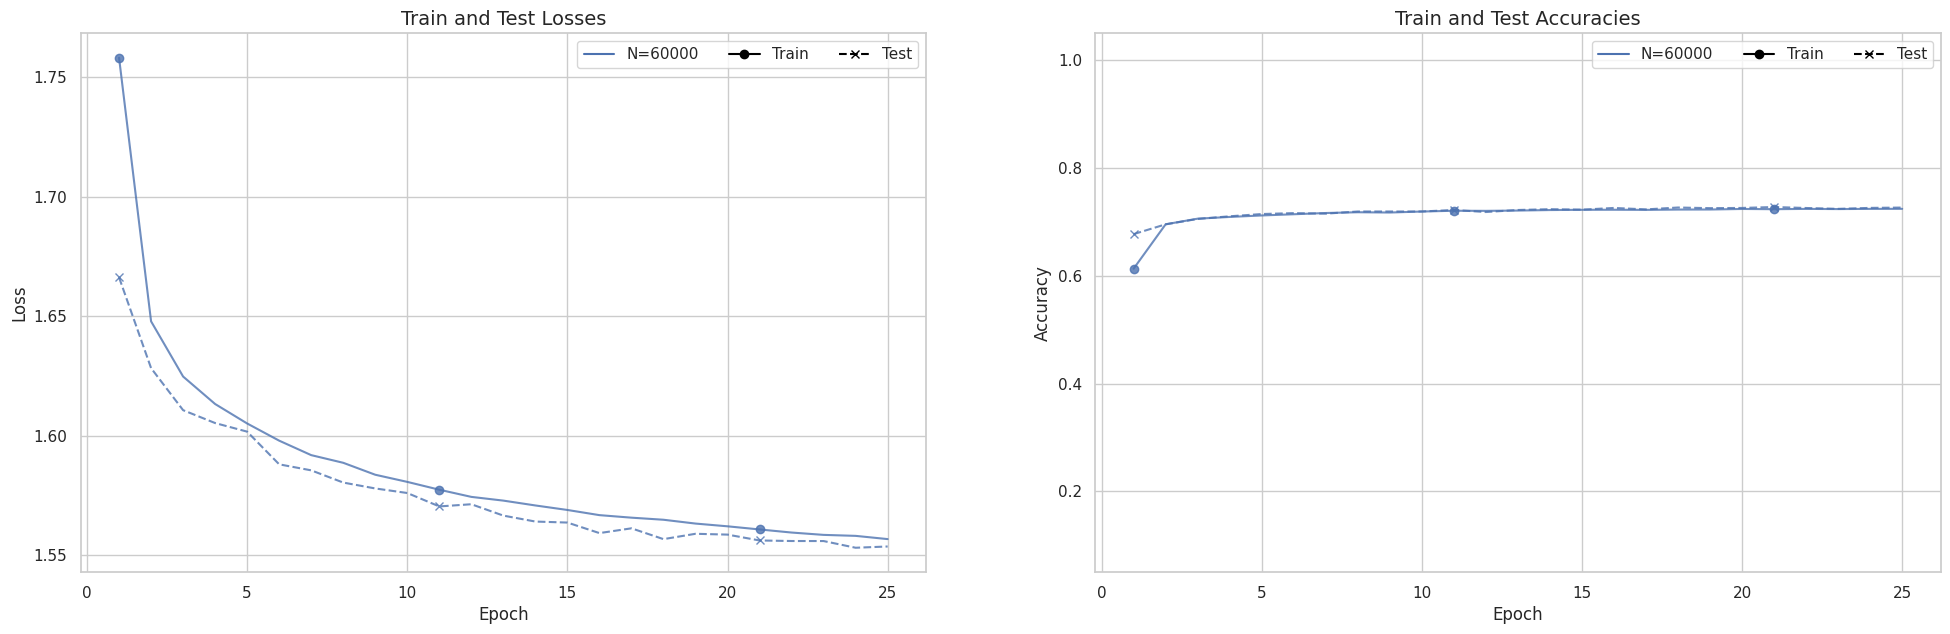

In [13]:
# aggregate dataframe
df_agg = results_df.groupby(["n_train", "step"]).agg(["mean", "std"])
df_agg = df_agg.reset_index()

sns.set_style('whitegrid')
colors = sns.color_palette()
fig, axes = plt.subplots(ncols=2, figsize=(24, 7))

generalization_errors = []

# plot losses and accuracies
for i, n_train in enumerate(train_sizes):
    df = df_agg[df_agg.n_train == n_train]

    dfs = [df.train_cost["mean"], df.test_cost["mean"], df.train_acc["mean"], df.test_acc["mean"]]
    lines = ["o-", "x--", "o-", "x--"]
    labels = [fr"$N={n_train}$", None, fr"$N={n_train}$", None]
    axs = [0,0,1,1]

    for k in range(4):
        ax = axes[axs[k]]
        ax.plot(df.step, dfs[k], lines[k], label=labels[k], markevery=10, color=colors[i], alpha=0.8)


    # plot final loss difference
    #dif = df[df.step == n_epochs].test_cost["mean"] - df[df.step == n_epochs].train_cost["mean"]
    #generalization_errors.append(dif)

# format loss plot
ax = axes[0]
ax.set_title('Train and Test Losses', fontsize=14)
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')

# format generalization error plot
#ax = axes[1]
#ax.plot(train_sizes, generalization_errors, "o-", label=r"$gen(\alpha)$")
#ax.set_xscale('log')
#ax.set_xticks(train_sizes)
#ax.set_xticklabels(train_sizes)
#ax.set_title(r'Generalization Error $gen(\alpha) = R(\alpha) - \hat{R}_N(\alpha)$', fontsize=14)
#ax.set_xlabel('Training Set Size')

# format loss plot
ax = axes[1]
ax.set_title('Train and Test Accuracies', fontsize=14)
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.set_ylim(0.05, 1.05)

legend_elements = [
    mpl.lines.Line2D([0], [0], label=f'N={n}', color=colors[i]) for i, n in enumerate(train_sizes)
    ] + [
    mpl.lines.Line2D([0], [0], marker='o', ls='-', label='Train', color='Black'),
    mpl.lines.Line2D([0], [0], marker='x', ls='--', label='Test', color='Black')
    ]

axes[0].legend(handles=legend_elements, ncol=3)
axes[1].legend(handles=legend_elements, ncol=3)

#axes[1].set_yscale('log', base=2)
plt.show()

In [15]:
results_df
import pandas as pd
from google.colab import files

# Save the DataFrame to a CSV file
results_df.to_csv('beta_results_60k_25epoch.csv', index=False)

# Download the CSV file
files.download('beta_results_60k_25epoch.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [16]:
results_df

,train_acc,train_cost,test_acc,test_cost,step,n_train
0,0.613150,1.758174,0.6773,1.666239,1,60000
1,0.695533,1.647854,0.6955,1.628269,2,60000
2,0.705983,1.624746,0.7055,1.610666,3,60000
3,0.709200,1.613246,0.7104,1.605277,4,60000
4,0.711950,1.605096,0.7146,1.601679,5,60000
5,0.714200,1.597907,0.7163,1.587998,6,60000
6,0.716483,1.591850,0.7153,1.585480,7,60000
7,0.717917,1.588643,0.7193,1.580371,8,60000
8,0.717400,1.583643,0.7193,1.577905,9,60000
9,0.719233,1.580652,0.7193,1.575997,10,60000


In [ ]:
save_folder = "/content/drive/MyDrive/Research/HermtianEncodingImg/mnist"
results_df.to_csv(os.path.join(save_folder, "mnist_HermImgReUpload_results.csv"))
df_agg.to_csv(os.path.join(save_folder, "mnist_HermImgReUpload_results_agg.csv"))
# save the plot to file
fig.savefig(os.path.join(save_folder, "mnist_HermImgReUpload_results.png"))